**Table of contents**<a id='toc0_'></a>    
- [Introduccion](#toc1_)    
- [Procesamiento de datos](#toc2_)    
  - [Carga de datasets e importacion de librerias](#toc2_1_)    
  - [Estudio de datos](#toc2_2_)    
    - [Dataset Telecom](#toc2_2_1_)    
    - [Dataset clients](#toc2_2_2_)    
- [Analisis exploratorio de datos](#toc3_)    
  - [Tiempo de espera por llamada](#toc3_1_)    
  - [Histograma para ver la distribucion de las llamadas.](#toc3_2_)    
  - [ Diagrama de caja para identificar valores atipicos.](#toc3_3_)    
  - [Grafico de dispersion entre duracion de llamadas y el tiempo de espera](#toc3_4_)    
  - [Grafico de dispersion entre llamadas entrantes perdidas y tiempo de espera](#toc3_5_)    
  - [Calcular la correlacion entre llamadas entrantes perdidas y tiempo de espera](#toc3_6_)    
  - [Analisis de la distribución de variables con Shapiro-Wilk](#toc3_7_)    
- [Identifica los operadores ineficaces](#toc4_)    
  - [Identificar los criterios para llamadas perdidas y tiempo de espera, por medio del percentil 80](#toc4_1_)    
  - [Identificar que operadores caen en n categoria](#toc4_2_)    
  - [Porcentaje de operadores eficaces e ineficaces.](#toc4_3_)    
- [Prueba de Hipotesis](#toc5_)    
    - [Estimacion del Tamaño de Muestra](#toc5_1_1_)    
- [Conclusiones:](#toc6_)    
- [Recomendaciones:](#toc7_)    
- [Presentacion:](#toc8_)    
- [Dashboard:](#toc9_)    
- [Documentacion utilizada:](#toc10_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Introduccion](#toc0_)

El siguiente proyecto tiene como finalidad identificar los operadores ineficaces de la telefonia virtual CallMeMaybe. Este analisis servira de apoyo para los supervisores, en la toma de desiciones gerenciales a base de la eficiencia de cada operador.

# <a id='toc2_'></a>[Procesamiento de datos](#toc0_)

## <a id='toc2_1_'></a>[Carga de datasets e importacion de librerias](#toc0_)

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import datetime
from datetime import datetime
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import mannwhitneyu
from statsmodels.stats.power import TTestIndPower

In [2]:
telecom= pd.read_csv('telecom_dataset_us.csv')
clients= pd.read_csv('telecom_clients_us.csv')

In [3]:
telecom.head(5)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [4]:
clients.head(5)

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


## <a id='toc2_2_'></a>[Estudio de datos](#toc0_)

### <a id='toc2_2_1_'></a>[Dataset Telecom](#toc0_)

In [5]:
telecom.describe()

,user_id,operator_id,calls_count,call_duration,total_call_duration
count,53902.000000,45730.000000,53902.000000,53902.000000,53902.000000
mean,167295.344477,916535.993002,16.451245,866.684427,1157.133297
std,598.883775,21254.123136,62.917170,3731.791202,4403.468763
min,166377.000000,879896.000000,1.000000,0.000000,0.000000
25%,166782.000000,900788.000000,1.000000,0.000000,47.000000
50%,167162.000000,913938.000000,4.000000,38.000000,210.000000
75%,167819.000000,937708.000000,12.000000,572.000000,902.000000
max,168606.000000,973286.000000,4817.000000,144395.000000,166155.000000


In [6]:
telecom.isna().sum()

user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

In [7]:
telecom_clean= telecom.dropna()
telecom_clean.isna().sum()

user_id                0
date                   0
direction              0
internal               0
operator_id            0
is_missed_call         0
calls_count            0
call_duration          0
total_call_duration    0
dtype: int64

Notas: 
- Para los datos ausentes del dataset de telecom decidi removerlos ya que eran datos que no darian un gran valor al estudip ya que era de operator ID y si era una llamada interna, en este caso el estudio esta enfocado en los operadores, asi que son valores que no se pueden rellenar. 

In [8]:
telecom_clean.duplicated().sum()

4179

In [9]:
telecom_clean.dtypes

user_id                  int64
date                    object
direction               object
internal                object
operator_id            float64
is_missed_call            bool
calls_count              int64
call_duration            int64
total_call_duration      int64
dtype: object

In [10]:
telecom_clean['date'] = pd.to_datetime(telecom_clean['date'],utc=True) 
telecom_clean['date'] = telecom_clean['date'].dt.tz_localize(None)
telecom_clean['direction'] = telecom_clean['direction'].astype('category')
telecom_clean['internal'] = telecom_clean['internal'].astype('category')
telecom_clean.dtypes

C:\Users\gabri\AppData\Local\Temp\ipykernel_18660\2289246030.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telecom_clean['date'] = pd.to_datetime(telecom_clean['date'],utc=True)
C:\Users\gabri\AppData\Local\Temp\ipykernel_18660\2289246030.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telecom_clean['date'] = telecom_clean['date'].dt.tz_localize(None)
C:\Users\gabri\AppData\Local\Temp\ipykernel_18660\2289246030.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

user_id                         int64
date                   datetime64[ns]
direction                    category
internal                     category
operator_id                   float64
is_missed_call                   bool
calls_count                     int64
call_duration                   int64
total_call_duration             int64
dtype: object

Nota:
- Se cambiaron los datos de las fechas para que estas tengan el tipo de dato requerido con el metodo to_datetime, eliminando la zona horaria ya que requerimos tener solamente la fecha de la interacion. Asi mismo, se cambio a datos a categorico con el metodo astype. 

### <a id='toc2_2_2_'></a>[Dataset clients](#toc0_)

In [11]:
clients.describe()

,user_id
count,732.000000
mean,167431.927596
std,633.810383
min,166373.000000
25%,166900.750000
50%,167432.000000
75%,167973.000000
max,168606.000000


In [12]:
clients.isna().sum()

user_id        0
tariff_plan    0
date_start     0
dtype: int64

In [13]:
clients.duplicated().sum()

0

In [14]:
clients.dtypes

user_id         int64
tariff_plan    object
date_start     object
dtype: object

In [15]:
clients['date_start'] = pd.to_datetime(clients['date_start'])
clients.dtypes

user_id                 int64
tariff_plan            object
date_start     datetime64[ns]
dtype: object

Nota:
- Se cambiaron los datos de las fechas para que estas tengan el tipo de dato requerido con el metodo to_datetime.

# <a id='toc3_'></a>[Analisis exploratorio de datos](#toc0_)

## <a id='toc3_1_'></a>[Tiempo de espera por llamada](#toc0_)

In [16]:
telecom_clean['waiting_time'] = telecom_clean['total_call_duration'] - telecom_clean['call_duration']
telecom_clean.head()

C:\Users\gabri\AppData\Local\Temp\ipykernel_18660\1158109357.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telecom_clean['waiting_time'] = telecom_clean['total_call_duration'] - telecom_clean['call_duration']


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time
1,166377,2019-08-04 21:00:00,out,True,880022.0,True,3,0,5,5
2,166377,2019-08-04 21:00:00,out,True,880020.0,True,1,0,1,1
3,166377,2019-08-04 21:00:00,out,True,880020.0,False,1,10,18,8
4,166377,2019-08-04 21:00:00,out,False,880022.0,True,3,0,25,25
5,166377,2019-08-04 21:00:00,out,False,880020.0,False,2,3,29,26


## <a id='toc3_2_'></a>[Histograma para ver la distribucion de las llamadas.](#toc0_)

c:\Users\gabri\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


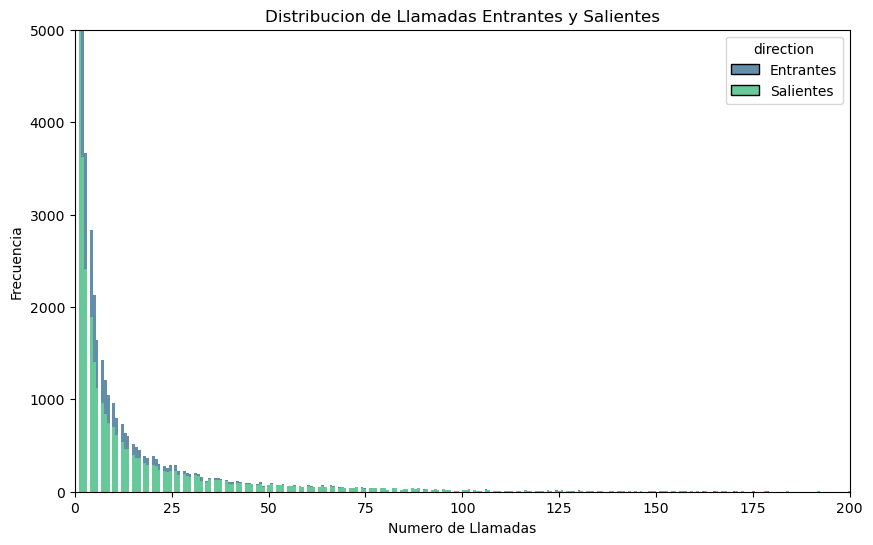

In [17]:
incoming_calls = telecom_clean.query('direction == "in"')[['calls_count']]
incoming_calls['direction'] = 'Entrantes'

outgoing_calls = telecom_clean.query('direction == "out"')[['calls_count']]
outgoing_calls['direction'] = 'Salientes'

combined_data = pd.concat([incoming_calls, outgoing_calls])

plt.figure(figsize=(10, 6))
sns.histplot(data=combined_data, x='calls_count', hue='direction', multiple='stack', palette='viridis')
plt.title('Distribucion de Llamadas Entrantes y Salientes')
plt.xlabel('Numero de Llamadas')
plt.ylabel('Frecuencia')
plt.xlim(0, 200)  
plt.ylim(0, 5000)  

plt.show()


Conclusion: Se puede notar en la grafica que la mayor cantidad de llamadas son entrantes. 

## <a id='toc3_3_'></a>[ Diagrama de caja para identificar valores atipicos.](#toc0_)

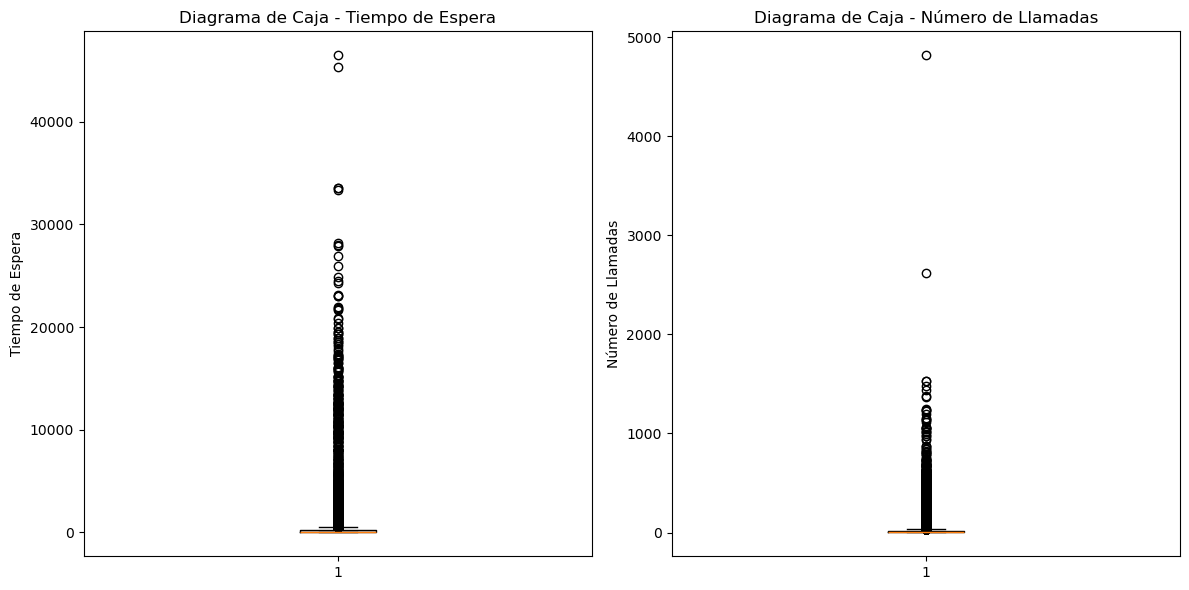

In [18]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.boxplot(telecom_clean['waiting_time'].dropna())
plt.title('Diagrama de Caja - Tiempo de Espera')
plt.ylabel('Tiempo de Espera')

plt.subplot(1, 2, 2)
plt.boxplot(telecom_clean['calls_count'])
plt.title('Diagrama de Caja - Número de Llamadas')
plt.ylabel('Número de Llamadas')

plt.tight_layout()
plt.show()

Nota: En la grafica de tiempo de espera se puede notar que hay una mayor cantidad de datos atipicos que en la de numero de llamadas. 

## <a id='toc3_4_'></a>[Grafico de dispersion entre duracion de llamadas y el tiempo de espera](#toc0_)

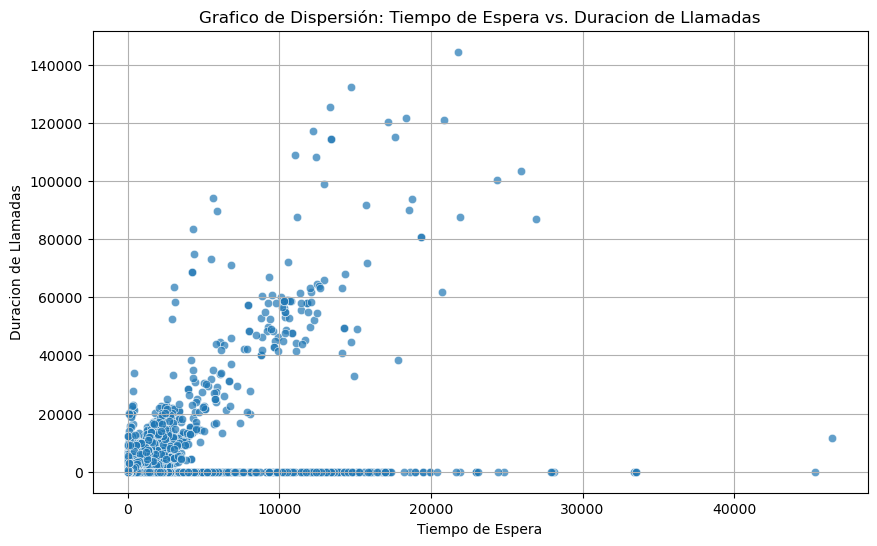

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=telecom_clean, x='waiting_time', y='call_duration', alpha=0.7)
plt.title('Grafico de Dispersión: Tiempo de Espera vs. Duracion de Llamadas')
plt.xlabel('Tiempo de Espera')
plt.ylabel('Duracion de Llamadas')
plt.grid(True)
plt.show()

Conclusion: Existe una correlacion lineal ascendente entre estas dos variable, a medida que aumentan el tiempo de espera aumenta tambien la duracion de las llamadas. 

## <a id='toc3_5_'></a>[Grafico de dispersion entre llamadas entrantes perdidas y tiempo de espera](#toc0_)

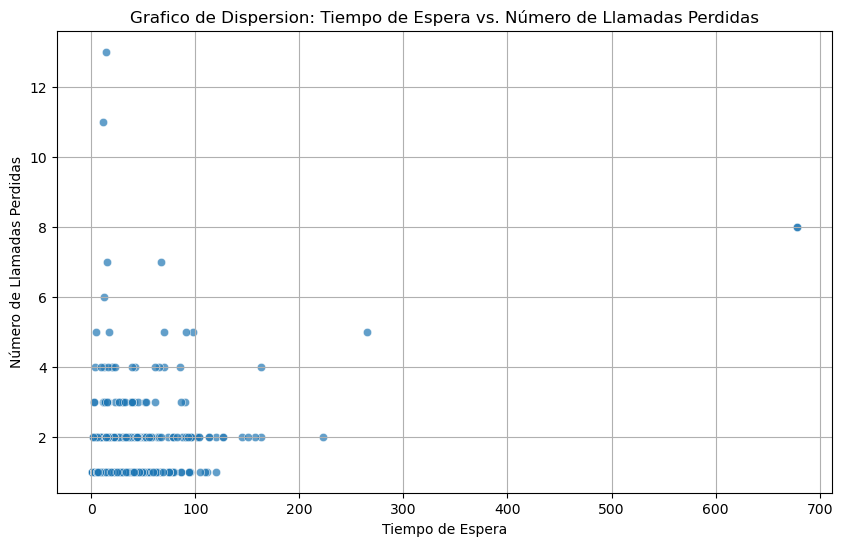

In [20]:
incoming_calls = telecom_clean[telecom_clean['direction'] == 'in']
missed_incoming_calls = incoming_calls[incoming_calls['is_missed_call'] == 1]
plt.figure(figsize=(10, 6))
sns.scatterplot(data=missed_incoming_calls, x='waiting_time', y='calls_count', alpha=0.7)
plt.title('Grafico de Dispersion: Tiempo de Espera vs. Número de Llamadas Perdidas')
plt.xlabel('Tiempo de Espera')
plt.ylabel('Número de Llamadas Perdidas')
plt.grid(True)
plt.show()


Conclusion: los datos cuentan con una tendencia pero estan divididos en subgrupos, por lo que se podria notar que hay otros factores que estan impactando los datos. 

## <a id='toc3_6_'></a>[Calcular la correlacion entre llamadas entrantes perdidas y tiempo de espera](#toc0_)

In [21]:
correlation = missed_incoming_calls[['waiting_time', 'calls_count']].corr().iloc[0, 1]

print(f"Correlacion entre el tiempo de espera y el número de llamadas perdidas: {correlation:.2f}")

Correlacion entre el tiempo de espera y el número de llamadas perdidas: 0.41


Conclusion: Existe una correlacion positiva moderada entre ambas variable, lo que podria establecer que en algunas ciircunstacias si el tiempo de espera aumenta, las llamadas perdidas aumentaran a su vez, pero no de manera uniforme. 

## <a id='toc3_7_'></a>[Analisis de la distribución de variables con Shapiro-Wilk](#toc0_)

In [22]:
key_variable = ['call_duration', 'waiting_time', 'calls_count']

def shapiro_test(data):
    stat, p_value = st.shapiro(data)
    return stat, p_value

# Realizar la prueba de Shapiro-Wilk para cada variable clave
for variable in key_variable:
    stat, p_value = shapiro_test(telecom_clean[variable].dropna())
    print(f'Variable: {variable}')
    print(f'Estadístico de Shapiro-Wilk: {stat:.4f}')
    print(f'Valor p: {p_value:.4f}')
    
    if p_value < 0.05:
        print('Los datos no siguen una distribución normal.')
    else:
        print('Los datos siguen una distribución normal.')
    print()

Variable: call_duration
Estadístico de Shapiro-Wilk: 0.2070
Valor p: 0.0000
Los datos no siguen una distribución normal.

Variable: waiting_time
Estadístico de Shapiro-Wilk: 0.2174
Valor p: 0.0000
Los datos no siguen una distribución normal.

Variable: calls_count
Estadístico de Shapiro-Wilk: 0.2157
Valor p: 0.0000
Los datos no siguen una distribución normal.



c:\Users\gabri\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Conclusion: Las 3 variables de estudio no cuentan con una distribucion normal. 

# <a id='toc4_'></a>[Identifica los operadores ineficaces](#toc0_)

## <a id='toc4_1_'></a>[Identificar los criterios para llamadas perdidas y tiempo de espera, por medio del percentil 80](#toc0_)

In [23]:
operator_data = telecom_clean.groupby('operator_id').agg({
    'is_missed_call': 'sum',          
    'calls_count': 'sum',               
    'waiting_time': 'mean',          
    'call_duration': 'mean'            
}).reset_index()
operator_data.head()

,operator_id,is_missed_call,calls_count,waiting_time,call_duration
0,879896.0,50,1131,110.671875,650.476562
1,879898.0,100,7973,451.860000,1115.504000
2,880020.0,7,54,15.181818,104.090909
3,880022.0,33,219,57.565789,240.842105
4,880026.0,94,2439,121.171717,856.939394


In [24]:
threshold_missed_calls = operator_data['is_missed_call'].quantile(0.80) 
threshold_waiting_time = operator_data['waiting_time'].quantile(0.80) 
print('Criterio para llamada perdidas:',threshold_missed_calls)
print('Criterio para tiempo de esperan(sg):',threshold_waiting_time)

Criterio para llamada perdidas: 24.0
Criterio para tiempo de esperan(sg): 223.8275768840827


## <a id='toc4_2_'></a>[Identificar que operadores caen en n categoria](#toc0_)

c:\Users\gabri\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\gabri\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\gabri\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\gabri\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\gabri\anaconda3\Lib\site-packages\sklearn\clust

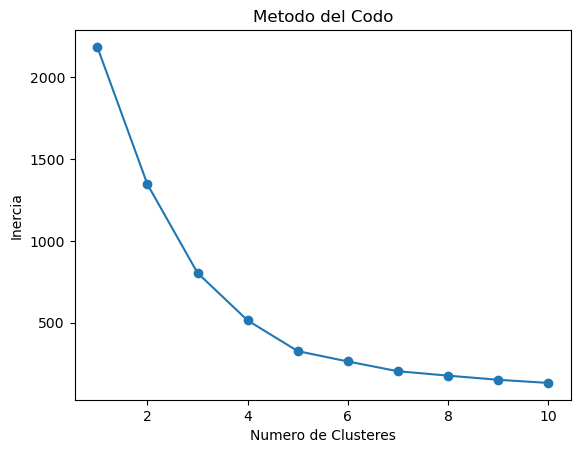

In [25]:
features = operator_data[['is_missed_call', 'waiting_time']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Numero de Clusteres')
plt.ylabel('Inercia')
plt.title('Metodo del Codo')
plt.show()

In [26]:
kmeans = KMeans(n_clusters=4, random_state=42)
operator_data['cluster'] = kmeans.fit_predict(scaled_features)
operator_data.head()

c:\Users\gabri\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,operator_id,is_missed_call,calls_count,waiting_time,call_duration,cluster
0,879896.0,50,1131,110.671875,650.476562,0
1,879898.0,100,7973,451.860000,1115.504000,0
2,880020.0,7,54,15.181818,104.090909,2
3,880022.0,33,219,57.565789,240.842105,0
4,880026.0,94,2439,121.171717,856.939394,0


In [27]:
cluster_summary = operator_data.groupby('cluster').agg({
    'is_missed_call': 'mean',
    'waiting_time': 'mean',
    'operator_id': 'count'
}).rename(columns={'operator_id': 'count'})
cluster_summary

,is_missed_call,waiting_time,count
cluster,,,
0,52.267081,194.951429,161
1,62.000000,4758.196868,6
2,6.243990,71.266997,832
3,16.505376,1249.555076,93


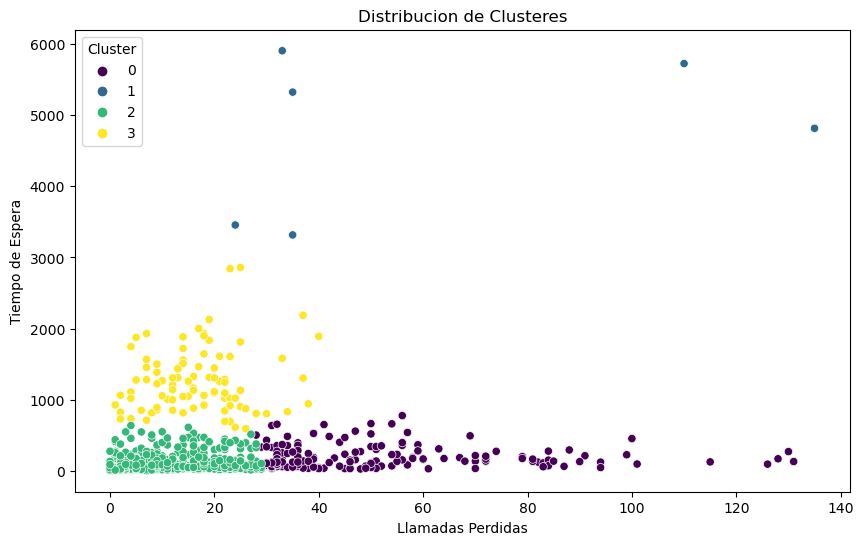

In [28]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=operator_data, x='is_missed_call', y='waiting_time', hue='cluster', palette='viridis')
plt.title('Distribucion de Clusteres')
plt.xlabel('Llamadas Perdidas')
plt.ylabel('Tiempo de Espera')
plt.legend(title='Cluster')
plt.show()

Conclusion: Teniendo en cuenta la curva, se definieron 4 cluster, que estan bastante alineados con los parametros establecidos en las empresas de servicio al cliente. Se puede notar que la mayoria de operadores se encuentran ubicados en el cluster numero 2.

## <a id='toc4_3_'></a>[Porcentaje de operadores eficaces e ineficaces.](#toc0_)

In [29]:
operator_data['is_ineffective'] = (
    (operator_data['is_missed_call'] > threshold_missed_calls) &
    (operator_data['waiting_time'] > threshold_waiting_time)
)
effective_operartors = operator_data[~operator_data['is_ineffective']]['is_missed_call']
ineffective_operators = operator_data[operator_data['is_ineffective']]['is_missed_call']

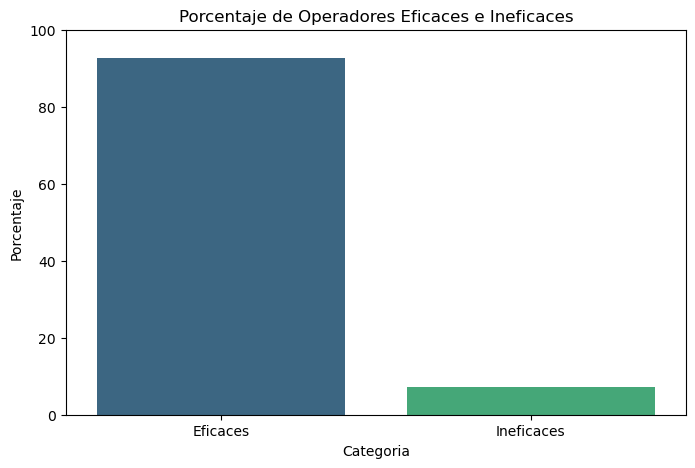

In [30]:
total_operators = operator_data.shape[0]
percentage_ineffective = (ineffective_operators.shape[0] / total_operators) * 100
percentage_effective = 100 - percentage_ineffective

percentage_data = pd.DataFrame({
    'Category': ['Eficaces', 'Ineficaces'],
    'Percentage': [percentage_effective, percentage_ineffective]
})
plt.figure(figsize=(8, 5))
sns.barplot(x='Category', y='Percentage', data=percentage_data, palette='viridis')
plt.title('Porcentaje de Operadores Eficaces e Ineficaces')
plt.xlabel('Categoria')
plt.ylabel('Porcentaje')
plt.ylim(0, 100) 
plt.show()

# <a id='toc5_'></a>[Prueba de Hipotesis](#toc0_)

Determinar si hay una diferencia significativa en las llamadas entrantes perdidas entre los operadores eficaces e ineficaces. 

-Hipotesis Nula: No hay diferencia significativa en el número de llamadas entrantes perdidas entre operadores eficaces e ineficaces.

Se usara la prueba Mann-Whitney U debido a que los resultados no tienen una varianza normal.


In [31]:
u_stat, p_value = mannwhitneyu(effective_operartors, ineffective_operators, alternative='two-sided')
if p_value < 0.05:
    print('Se rechaza la hipotesis nula.')
else:
    print('Se acepta la hipotesis nula.')

Se rechaza la hipotesis nula.


### <a id='toc5_1_1_'></a>[Estimacion del Tamaño de Muestra](#toc0_)

In [32]:
effect_size = 0.3
alpha = 0.05       
power = 0.8        

power_analysis = TTestIndPower()
sample_size = power_analysis.solve_power(effect_size, power=power, alpha=alpha, alternative='two-sided')

print(f"Tamaño de muestra necesario: {sample_size:.2f}")

Tamaño de muestra necesario: 175.38


# <a id='toc6_'></a>[Conclusiones:](#toc0_)

- Se pudo determinar que si existe una relación entre las llamadas perdidas con el tiempo de espera. 
- Se tiene un porcentaje de menos del 10% de operadores ineficaces, lo cual puede denotar que solo tenemos pocos operadores que están impactando los resultados de la operación. 
- Los operadores ineficaces están teniendo mayor cantidad de llamadas perdidas por los tiempos altos de espera. 
- Se tiene una limitante en el estudio ya que no se cuentan con otros factores que midan la calidad de las llamadas tomadas por los operadores, o las encuestas realizadas por los usuarios. Se podría realizar un análisis con estas variables adicionales para poder determinar cómo están afectando estos usuarios a la operación. Así mismo realizar el análisis de clúster con el tiempo de permanencia de los operadores en la línea.


# <a id='toc7_'></a>[Recomendaciones:](#toc0_)


- Se podría realizar una jornada de entrenamiento para los operadores ineficaces que cuenten con menos de 90 días en la operación, ya que estos pueden tener algunas falencias en el manejo de herramientas. 
- Se recomienda realizar un análisis de impacto en la relación con el cliente final, usando como variables los resultados de las encuestas. 
- Realizar una revisión de los criterios de operadores ineficaces, y generar criterios basados en el tiempo de permanencia del operador en la compañía. 
- Realizar un análisis aleatorio de algunas de las llamadas de los operadores ineficaces para determinar que otros factore podrían estar impactando.

# <a id='toc8_'></a>[Presentacion:](#toc0_)

https://1drv.ms/b/c/1abe78004869dda4/EYg6zm1FEcRAqomLbBFSVrABPZ-y1E7rAZjayQvaZAg4cg?e=coBkHB

# <a id='toc9_'></a>[Dashboard:](#toc0_)

https://public.tableau.com/shared/5FPRNWRFS?:display_count=n&:origin=viz_share_link

# <a id='toc10_'></a>[Documentacion utilizada:](#toc0_)

- scipy.stats: https://docs.scipy.org/doc/scipy/reference/main_namespace.html
- Seaborn: https://seaborn.pydata.org/
- Calculo de correlacion: https://ndmarketingdigital.com/como-calcular-la-correlacion-de-pearson-en-python/
- Shapiro-wilk: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html
- Mann-Whitney U: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html

